In [1]:
# This is required to run multiple processes on Unity for some reason.
from multiprocessing import set_start_method
set_start_method('forkserver', force=True)


import os
os.environ['XLA_FLAGS'] = '--xla_gpu_enable_command_buffer='
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION'] = '0.7'
# os.environ['JAX_PLATFORMS'] = 'cpu'

In [2]:
%matplotlib widget
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import jax
import jax.numpy as jnp
import pickle
from tqdm.auto import tqdm
from pathlib import Path
from copy import deepcopy

src = str(Path('../src').resolve())
if src not in sys.path:
    sys.path.append(src)

from train import load_last_state
from data import HydroDataset, HydroDataLoader
import config

In [3]:
run_dir = Path("../runs/SWOT_Q_gridmet/base_config_20241204_174138")
cfg, model, trainer_state, opt_state, _ = load_last_state(run_dir)

cfg['num_workers'] = 1
cfg['quiet'] = False
cfg['batch_size'] = 64
cfg['data_subset'] = 'train'
key = jax.random.PRNGKey(0)
keys = jax.random.split(key, cfg['batch_size'])

fig_dir = run_dir / "figures" / "feature_importance"
fig_dir.mkdir(exist_ok=True, parents=True)

Loading model state from ../runs/SWOT_Q_gridmet/base_config_20241204_174138/epoch030
Model contains 120,257 parameters, using 469.75KB memory.


In [ ]:
# label_name_dict = {
#     'snowmelt_sum': 'Snowmelt',
#     'Blue': 'Blue',
#     'Swir2': 'SWIR 2',
#     'Green': 'Green',
#     'surface_runoff_sum': 'Surface runoff',
#     'total_evaporation_sum': 'Evaporation',
#     'Swir1': 'SWIR 1',
#     'Red': 'Red',
#     'surface_solar_radiation_downwards_sum': 'Shortwave radiation',
#     'dw': 'Dominant wavelength',
#     'surface_thermal_radiation_downwards_sum': 'Longwave radiation',
#     'temperature_2m': 'Air temperature (2m)',
#     'pCount_dswe1': 'Inundated pixel count',
#     'Surface_temp_kelvin': 'Surface temperature',
#     'Nir': 'NIR',
#     'hue': 'Hue',
#     'total_precipitation_sum': 'Precipitation'
# }

In [48]:
def get_avg_importance(gradients, batch, feat_key):
    inputs = np.array(batch['dynamic'][feat_key])
    grads = np.array(gradients['dynamic'][feat_key])
    imp = np.nanmean(np.abs(grads * inputs),axis=(0,1))
    return imp

def get_batch_grad_importance(model, batch, target_idx):
    """
    Compute feature importance using gradient magnitudes.
    """
    def loss_fn(b):
        pred = jax.vmap(model)(b, keys)
        err = pred[:,target_idx] - b['y'][:,-1,target_idx]
        return jnp.nanmean(err**2)
    
    for k in batch['dynamic'].keys():
        batch['dynamic'][k] = np.nan_to_num(batch['dynamic'][k])

    # Compute gradients with respect to input
    grad_fn = jax.grad(loss_fn)
    grads = grad_fn(batch)
    
    era5_imp = get_avg_importance(grads, batch, 'gridmet')
    ls_imp = get_avg_importance(grads, batch, 'swot')
    
    return np.concat([era5_imp, ls_imp])


def get_importance(cfg, target, max_count=None):
    targets = cfg['features']['target']
    cfg['exclude_target_from_index'] = [t for t in targets if t != target]
    dataset = HydroDataset(cfg)
    cfg = config.set_model_data_args(cfg, dataset)
    dataloader = HydroDataLoader(cfg, dataset)
    
    importance_list = []
    for basin, date, batch in tqdm(dataloader):
        batch = dataloader.shard_batch(batch)
        batch.pop('dynamic_dt')
        
        batch_importance = get_batch_grad_importance(model, batch, targets.index(target))
        importance_list.append(batch_importance)
        
        if max_count and len(importance_list)>=max_count:
            break
       
    importance = np.mean(np.stack(importance_list), axis=0) 
    
    labels = []
    labels.extend(dataset.features['dynamic']['gridmet'])
    labels.extend(dataset.features['dynamic']['swot'])
    use_cols = ['pixel' not in l and 'sat' not in l for l in labels]
    filtered_labels = [l for l, use in zip(labels, use_cols) if use]
    
    colors = ['tab:blue'] * len(dataset.features['dynamic']['gridmet']) 
    colors.extend(['tab:orange'] * len(dataset.features['dynamic']['swot']))
    filtered_colors = [c for c, use in zip(colors, use_cols) if use]
    
    filtered_importance = importance[use_cols]
    
    sort = np.argsort(filtered_importance)
    sorted_importance = filtered_importance[sort]
    sorted_labels = [filtered_labels[i] for i in sort]
    sorted_colors = [filtered_colors[i] for i in sort]
    
    return sorted_labels, sorted_importance, sorted_colors 


In [ ]:
import pickle

for target in ['discharge']:
    data = get_importance(cfg, target, 100)
    
    with open(fig_dir / f'{target}_importance_data.pkl', 'wb') as file:
        pickle.dump(data, file)

In [41]:
importance

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.30460592e-07, 1.33638991e-07, 6.81876600e-07,
       7.26642895e-07, 8.57752752e-07, 9.24048152e-07, 1.11591942e-06,
       2.52918926e-06, 2.93448807e-06, 3.79662902e-06, 3.92357560e-06,
       4.13625457e-06, 6.34282287e-06, 6.85242549e-06, 7.41956046e-06,
       8.52792255e-06, 8.61742865e-06, 9.32472994e-06, 1.02261583e-05,
       1.03652828e-05, 1.15865951e-05, 1.26616014e-05, 1.28961437e-05,
       1.31520246e-05, 1.35284135e-05, 1.39098665e-05, 1.45262675e-05,
       1.49250482e-05, 1.51222293e-05, 1.61750522e-05, 1.68851220e-05,
       1.69576924e-05, 1.88787508e-05, 2.12208615e-05, 2.15071541e-05,
       2.20899747e-05, 2.20918446e-05, 2.30325822e-05, 3.41281375e-05,
       3.98880620e-05, 4.99423186e-05, 6.19237762e-05], dtype=float32)

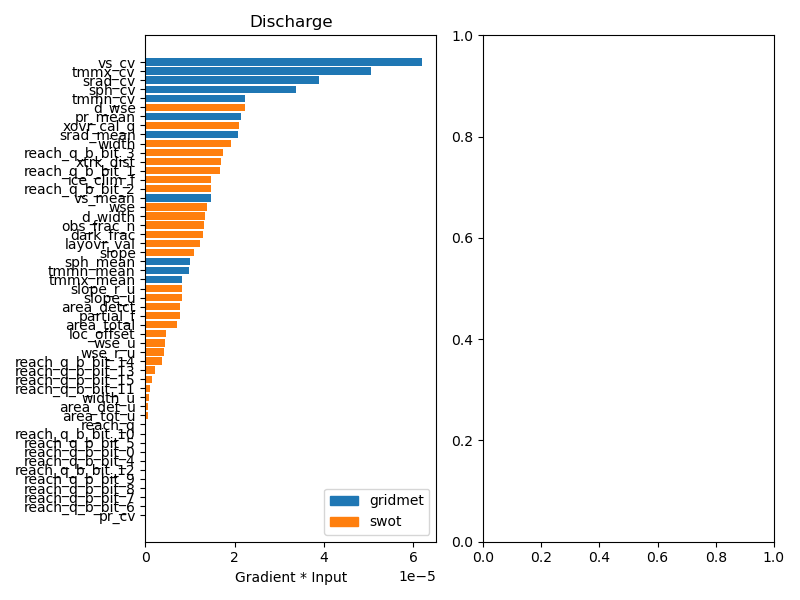

In [59]:
targets = ['discharge']
names = ['Discharge']
ticks = [np.linspace(0, 0.00005, 4),
         np.linspace(0, 0.0006, 4),
         np.linspace(0, 0.0002, 3)]

# Create legend patches
patches = [mpatches.Patch(color='tab:blue', label='gridmet'),
           mpatches.Patch(color='tab:orange', label='swot')]

plt.close('all')
fig, axes = plt.subplots(1, 2, figsize=(8,6))


for ax, target, name, tick in zip(axes, targets, names, ticks):
    pkl_file = fig_dir / f'{target}_importance_data.pkl'
    with open(pkl_file, 'rb') as file:
        labels, importance, colors = pickle.load(file)
    
    # better_labels = [label_name_dict[k] for k in labels]
    # ax.barh(better_labels, importance, color=colors)
    ax.barh(labels, importance, color=colors)

    # Add the legend to the bottom right
    ax.legend(handles=patches, loc='lower right')
    
    ax.set_title(f"{name}")
    ax.set_xlabel("Gradient * Input")
    # ax.set_xticks(tick)
    # ax.ticklabel_format(style='sci', axis='x', useMathText=True, scilimits=(0,0))

plt.tight_layout()

fig.savefig(fig_dir / "feature_importance.png",  dpi=300)

In [ ]:
ax.get_xlim()[1]

In [ ]:
np.linspace(0, 0.0004, 5)

In [ ]:
ax.set_xticks(np.linspace(0, 0.0004, 5))
fig.savefig(fig_dir / "q_feature_importance.png",  dpi=300)

In [ ]:
labels